In [30]:
import numpy as np
import healpy as hp
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u

def redshift_from_freq(freq_MHz):
    """Convert frequency in MHz to redshift."""
    nu_21 = 1420.40575  # MHz
    return (nu_21 / freq_MHz) - 1

def T_bar(z, Omega_HI=1e-3, h=0.674):
    """Compute mean 21cm brightness temperature in mK."""
    H_z = cosmo.H(z).value  # H(z) in km/s/Mpc
    H0 = cosmo.H0.value     # H0 in km/s/Mpc
    return 44 * Omega_HI * h * ((1 + z)**2) / (H_z / H0)  # in uK

def calibrate_hi_maps(freqs_MHz, uncalibrated_maps, Omega_HI=2.45e-4, h=0.7):
    """
    Calibrate uncalibrated HI maps to brightness temperature [mK].

    Parameters:
    - freqs_MHz: array-like, list of frequency values in MHz
    - uncalibrated_maps: list or array of maps (shape [nfreqs, npix])
    - Omega_HI: fractional HI density
    - h: reduced Hubble parameter

    Returns:
    - calibrated_maps: array of maps in mK, same shape as input
    - Tbars: array of T̄_b(z) used for each frequency
    """
    freqs_MHz = np.asarray(freqs_MHz)
    uncalibrated_maps = np.asarray(uncalibrated_maps)
    nfreqs = len(freqs_MHz)-1
    
    Tbars = np.zeros(nfreqs)
    calibrated_maps = np.zeros_like(uncalibrated_maps)

    for i, freq in enumerate(freqs_MHz[:-1]):
        z = redshift_from_freq(freq)
        Tbars[i] = T_bar(z, Omega_HI, h)
        calibrated_maps[i] = uncalibrated_maps[i] * Tbars[i]

    return calibrated_maps, Tbars


In [31]:
maps=np.load('hi_maps.npy')

In [32]:
nside = 256
npix = hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10) #instead of steps of1MHz use 10
nfreqs=54



# Calibrate to brightness temperature
cal_maps, Tbars = calibrate_hi_maps(freqs, maps)

print("T̄_b [uK] per freq:", Tbars)


T̄_b [uK] per freq: [0.02067157 0.02042038 0.02017362 0.01993109 0.0196926  0.01945798
 0.01922705 0.01899969 0.01877573 0.01855506 0.01833756 0.01812312
 0.01791162 0.01770299 0.01749712 0.01729395 0.01709338 0.01689536
 0.01669982 0.01650669 0.01631593 0.01612748 0.01594128 0.0157573
 0.0155755  0.01539584 0.01521828 0.01504278 0.01486932 0.01469787
 0.0145284  0.01436088 0.01419529 0.01403162 0.01386983 0.0137099
 0.01355183 0.01339558 0.01324115 0.01308851 0.01293765 0.01278855
 0.0126412  0.01249559 0.0123517  0.01220951 0.01206901 0.01193019
 0.01179304 0.01165754 0.01152367 0.01139144 0.01126081 0.01113178]


In [33]:
cal_maps.shape

(54, 786432)

In [34]:
np.save('calibrated_hi_maps.npy', cal_maps)

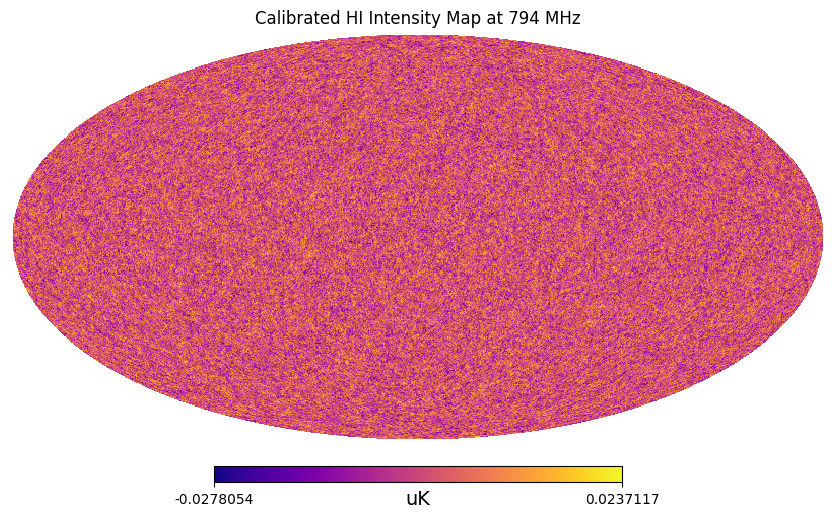

In [39]:
hp.mollview(cal_maps[25], title='Calibrated HI Intensity Map at 794 MHz', unit='uK', cmap='plasma')